<a href="https://colab.research.google.com/github/zihadbappy/bnfake/blob/main/BnFake_BanglaBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/zihadbappy/bnfakedata.git

In [ ]:
import pandas as pd
Dataset= pd.read_csv('/content/bnfakedata/bnfakefinal.csv')

In [ ]:
df = pd.DataFrame(Dataset)

In [ ]:
df=df.dropna(how='any',axis=0)

In [ ]:
X=df.content
Y=df.label

In [ ]:
df.groupby('label').agg('count')


In [ ]:
Y.value_counts()

In [ ]:
X.shape


In [9]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 6.5 MB/s 
     |████████████████████████████████| 6.6 MB 32.9 MB/s 
     |████████████████████████████████| 120 kB 48.9 MB/s 


In [10]:
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [11]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['headline']+"[SEP]"+value['content'] , value['label']

In [12]:
class NewsBert(nn.Module):

    def __init__(self, bert):
        super(NewsBert, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x
      

In [13]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)


Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewsBert(bert)
model.to(device);

In [15]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [16]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.25, random_state=121, stratify=df['label'])

In [17]:
len(train_df), len(test_df)

(4184, 1395)

In [18]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)

In [19]:
type(training_data)

__main__.NewsDatasets

In [20]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)

In [21]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [22]:
epochs = 5
tokenizer_config = {
    "max_length": 300,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [23]:
def train(model, dataloader, optimizer, criterion, config):
    model.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [24]:
test_df

,headline,content,label
5421,এমপি রনজিত রায়ের বিরুদ্ধে স্থানীয় নেতাদের যত অ...,যশোর আসনের সংসদ সদস্য এমপি রনজিত কুমার রায়ের ব...,1
2236,অবসরই নিয়ে ফেললেন আফ্রিদি দৈনিক মতিকণ্ঠ,মনলাইন ডেস্ক তারিখ গত বছর টেস্ট ক্রিকেট অবসর ন...,0
3097,কুমার বিশ্বজিৎ ও হাবিবকে নিয়ে পূর্ণিমা,বর্তমানে প্রচারিত দেশের জনপ্রিয় অনুষ্ঠানগুলোর ...,1
4563,পাহাড়ের রাজনীতি নিয়ে যত কথা,পাহাড়ের রাজনীতিতে ঘটছে পরিবর্তন তেমনি ইতিহাসে ...,1
3350,শাবির ছাত্রী হলে ফের চুরি,বৃহস্পতিবার ভোরে ছাত্রী হলের ডি ব্লকের নিচতলায়...,1
...,...,...,...
4746,শোয়ার ঘরে সাপের দংশনে কলেজছাত্রের মৃত্যু,নীলফামারীর ডিমলায় বিষধর সাপের দংশনে জাহিদুল ইস...,1
753,পুড়ে গেলে তাৎক্ষণিক ভাবে যা করবেন,দুর্ঘটনা কয়ে আসে রান্না কোনোভাবেই আগুনে দগ্ধ আ...,0
2427,এই শীত কাটিয়ে দিন গোসল না করেই জেনে নিন গোসলের...,কথায় এক ঋতুর আরাম ঋতুর হারাম হ্যাঁ গোসলের কথাই...,0
1785,আনোয়ারের অডিও ফাঁসের প্রতিবাদে হরতাল,মার্কিন যুক্তরাস্ট্রের মুসলমান প্রেসিডেন্ট বার...,0


In [26]:
train_loss_data=[]
valid_loss_data = []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
  print("Epoch: {}/{}".format(epoch + 1, epochs))
  # monitor training loss
  train_loss = 0.0
  valid_loss = 0.0
  total = 0
  correct = 0
  e_since = time.time()

    # Train Model
  train_loss += train(model, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
  out = evaluate(model, test_dataloader, criterion, tokenizer_config)
  total += out[0]
  correct += out[1]
  valid_loss += out[2]  
  scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
  train_loss = train_loss / len(train_dataloader.dataset)
  valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
  train_loss_data.append(train_loss * 100)
  valid_loss_data.append(valid_loss * 100)
    
  if valid_loss < best_loss:
    best_loss = valid_loss
    torch.save(model.state_dict(), "news_model1.pth")
    
  print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/523 [00:00<?, ?it/s]

	Train loss:0.361621.. 	Valid Loss:0.312963.. 	Accuracy: 90.6810
Epoch: 2/5


  0%|          | 0/523 [00:00<?, ?it/s]

	Train loss:0.207197.. 	Valid Loss:0.308246.. 	Accuracy: 92.3297
Epoch: 3/5


  0%|          | 0/523 [00:00<?, ?it/s]

	Train loss:0.084106.. 	Valid Loss:0.320961.. 	Accuracy: 93.1183
Epoch: 4/5


  0%|          | 0/523 [00:00<?, ?it/s]

	Train loss:0.063981.. 	Valid Loss:0.306909.. 	Accuracy: 93.6918
Epoch: 5/5


  0%|          | 0/523 [00:00<?, ?it/s]

	Train loss:0.049478.. 	Valid Loss:0.310695.. 	Accuracy: 93.9068
Training completed in 26m 37s


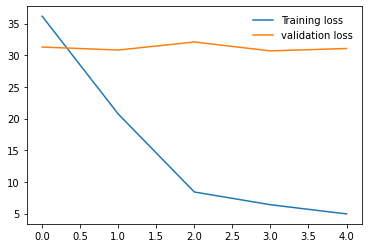

In [27]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [28]:
model.load_state_dict(torch.load("./news_model1.pth", map_location = device))

<All keys matched successfully>

In [29]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [30]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       698
           1       0.92      0.95      0.94       697

    accuracy                           0.94      1395
   macro avg       0.94      0.94      0.94      1395
weighted avg       0.94      0.94      0.94      1395



In [31]:
all_labels[1000:1020]

[1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]

In [32]:
all_preds[1000:1020]

[1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]